In [135]:
from RLS import RLS
from RLS import rls_predict_and_train
from RLS import generate_force_samples
from RLS import covariance

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [136]:
def load_trajectory_data(filepath):
    
    # Load the data using pandas
    data = pd.read_csv(filepath)
    
    return data

In [137]:
traj = load_trajectory_data("trayectorias_data/DroneFlightData/WithoutTakeoff/2020-0612/01/0612_2020_113939_01.csv")

In [138]:
traj.head()

,date,time,lat,lon,alt,x_gyro,y_gyro,z_gyro,x_acc,y_acc,z_acc,north,east,down,pitch,yaw,roll,wind_speed,wind_direction
0,2020/6/12,11:39:59,22.902893,120.273150,18.561,-151.0,-68.0,-19.0,-29.0,13.0,-889.0,0.252038,-0.626877,-18.561216,-0.077519,-2.171756,0.035489,9.0,53.0
1,2020/6/12,11:40:01,22.902875,120.273151,19.979,-94.0,-79.0,-20.0,-56.0,46.0,-968.0,-1.784565,-0.515358,-19.979485,-0.063647,-2.182642,-0.055300,9.0,53.0
2,2020/6/12,11:40:04,22.902811,120.273158,20.097,-10.0,35.0,-9.0,-38.0,-15.0,-1005.0,-8.935192,0.198706,-20.097517,-0.105956,2.927023,-0.000978,9.0,53.0
3,2020/6/12,11:40:06,22.902725,120.273176,20.108,-15.0,-39.0,40.0,-78.0,6.0,-995.0,-18.519846,1.992477,-20.108141,-0.083917,2.973798,0.018678,9.0,53.0
4,2020/6/12,11:40:09,22.902633,120.273195,20.181,-62.0,8.0,2.0,-65.0,-2.0,-963.0,-28.767178,3.951110,-20.181992,-0.141146,3.084772,0.009661,9.0,53.0


In [139]:
traj['time_delta'] = pd.to_timedelta(traj['time'])
traj['segundos'] = traj['time_delta'].dt.total_seconds()
traj['segundos'] = traj['segundos'] - traj['segundos'].min()

In [140]:
traj.head()

,date,time,lat,lon,alt,x_gyro,y_gyro,z_gyro,x_acc,y_acc,...,north,east,down,pitch,yaw,roll,wind_speed,wind_direction,time_delta,segundos
0,2020/6/12,11:39:59,22.902893,120.273150,18.561,-151.0,-68.0,-19.0,-29.0,13.0,...,0.252038,-0.626877,-18.561216,-0.077519,-2.171756,0.035489,9.0,53.0,0 days 11:39:59,0.0
1,2020/6/12,11:40:01,22.902875,120.273151,19.979,-94.0,-79.0,-20.0,-56.0,46.0,...,-1.784565,-0.515358,-19.979485,-0.063647,-2.182642,-0.055300,9.0,53.0,0 days 11:40:01,2.0
2,2020/6/12,11:40:04,22.902811,120.273158,20.097,-10.0,35.0,-9.0,-38.0,-15.0,...,-8.935192,0.198706,-20.097517,-0.105956,2.927023,-0.000978,9.0,53.0,0 days 11:40:04,5.0
3,2020/6/12,11:40:06,22.902725,120.273176,20.108,-15.0,-39.0,40.0,-78.0,6.0,...,-18.519846,1.992477,-20.108141,-0.083917,2.973798,0.018678,9.0,53.0,0 days 11:40:06,7.0
4,2020/6/12,11:40:09,22.902633,120.273195,20.181,-62.0,8.0,2.0,-65.0,-2.0,...,-28.767178,3.951110,-20.181992,-0.141146,3.084772,0.009661,9.0,53.0,0 days 11:40:09,10.0


In [141]:
# Extract the relevant columns
Traj = traj[['segundos', 'x_gyro', 'y_gyro', 'yaw', 'lat', 'lon', 'alt']]

In [142]:
Traj = Traj.dropna()

In [143]:
Traj.head()

,segundos,x_gyro,y_gyro,yaw,lat,lon,alt
0,0.0,-151.0,-68.0,-2.171756,22.902893,120.273150,18.561
1,2.0,-94.0,-79.0,-2.182642,22.902875,120.273151,19.979
2,5.0,-10.0,35.0,2.927023,22.902811,120.273158,20.097
3,7.0,-15.0,-39.0,2.973798,22.902725,120.273176,20.108
4,10.0,-62.0,8.0,3.084772,22.902633,120.273195,20.181


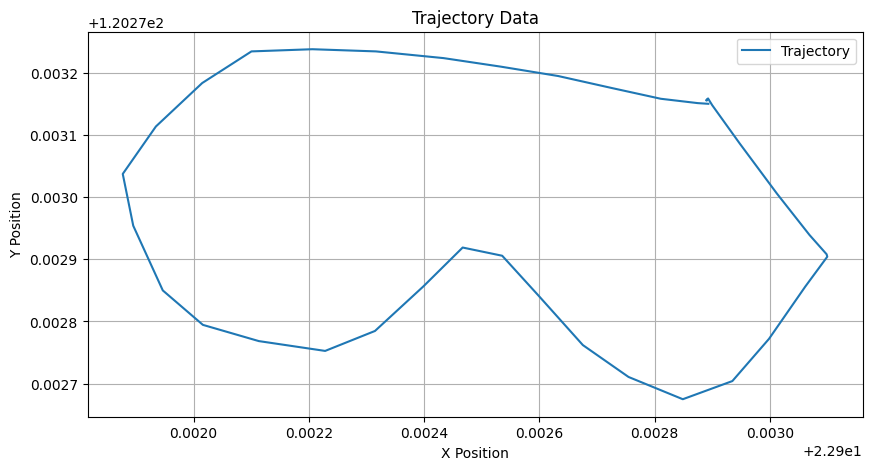

In [144]:
plt.figure(figsize=(10, 5))
plt.plot(Traj["lat"], Traj["lon"], label="Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory Data")
plt.legend()
plt.grid()
plt.show()


Dejamos que el modelo "mire"

In [145]:
# Time
T = len(Traj)

In [ ]:
view = 5  # Tamaño de la ventana de entrenamiento

all_preds = []

# Bucle desde view + 1 (para tener suficiente historial real)
for t in range(view + 1, T - 1):
    
    model = RLS(order=3*view)

    # Entrenar con múltiples ejemplos reales antes del paso t
    for j in range(t - view, t):
        history = [
            [Traj.iloc[i]['lat'], Traj.iloc[i]['lon'], Traj.iloc[i]['yaw']]
            for i in range(j - view, j)
        ]
        if len(history) < view:
            continue

        Xj = np.array(history).flatten().reshape(1, -1)
        Yj = np.array([
            Traj.iloc[j]['lat'],
            Traj.iloc[j]['lon'],
            Traj.iloc[j]['yaw']
        ]).reshape(1, -1)

        model.update(Xj, Yj)

    # Predecir 5 pasos futuros de forma autoregresiva
    X_real = np.array([
        [Traj.iloc[i]['lat'], Traj.iloc[i]['lon'], Traj.iloc[i]['yaw']]
        for i in range(t - view, t)
    ]).flatten().reshape(1, -1)

    preds = rls_predict_and_train(model, X_real, steps=5)

    # Guardar predicciones
    all_preds.append(np.squeeze(preds))



In [147]:
# Convertir a arrays para fácil manipulación
hist_arr = np.array(history)              # shape: (N, 3)
pred_arr = np.vstack(all_preds)           # stack all predictions

# Combinar todo para obtener límites seguros
all_lat = np.concatenate([hist_arr[:, 0], pred_arr[:, 0]])
all_lon = np.concatenate([hist_arr[:, 1], pred_arr[:, 1]])

# Calcular márgenes
lat_min, lat_max = all_lat.min(), all_lat.max()
lon_min, lon_max = all_lon.min(), all_lon.max()

c:\Users\maxic\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


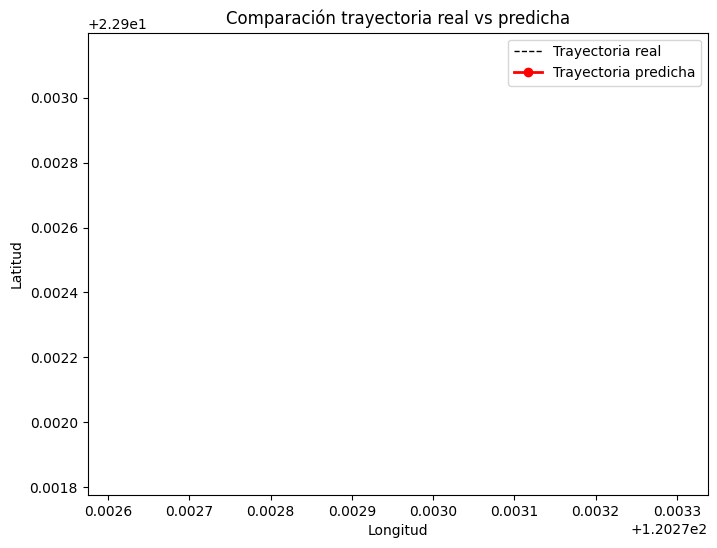

In [148]:
from matplotlib.animation import FuncAnimation

# Trajectoria real completa
traj_real = Traj[['lat', 'lon']].to_numpy()  # shape: (T, 2)

# Trajectory predicted (con flatten)
preds_arr = np.vstack(all_preds)[:, :2]  # lat, lon only

# Definir límites
lat_min, lat_max = traj_real[:, 0].min(), traj_real[:, 0].max()
lon_min, lon_max = traj_real[:, 1].min(), traj_real[:, 1].max()

# Crear figura
fig, ax = plt.subplots(figsize=(8, 6))
real_line, = ax.plot([], [], 'k--', label='Trayectoria real', linewidth=1)
pred_line, = ax.plot([], [], 'ro-', label='Trayectoria predicha', linewidth=2)

ax.set_xlim(lon_min - 0.0001, lon_max + 0.0001)
ax.set_ylim(lat_min - 0.0001, lat_max + 0.0001)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.legend()
ax.set_title("Comparación trayectoria real vs predicha")

# Animación
def actualizacion(frame):
    # Hasta el frame actual
    real_line.set_data(traj_real[:frame + 1, 1], traj_real[:frame + 1, 0])  # lon, lat
    pred_line.set_data(preds_arr[:frame + 1, 1], preds_arr[:frame + 1, 0])  # lon, lat
    return real_line, pred_line

ani = FuncAnimation(fig, actualizacion, frames=len(preds_arr), interval=400, blit=False)
plt.show()


In [149]:
all_preds

[array([[ 22.90310694, 120.27645823,   3.64547816],
        [ 22.90397369, 120.27732448, -19.58540391],
        [ 22.9037077 , 120.27256717, -23.36506791],
        [ 22.90315514, 120.27164608,  13.81082136],
        [ 22.90241324, 120.27147244,  19.78431497]]),
 array([[ 22.90318731, 120.27621803,  -0.65166028],
        [ 22.90309424, 120.27542102,  -1.98848366],
        [ 22.9034713 , 120.2763837 ,   3.04248762],
        [ 22.9029409 , 120.27449528,  -0.82980877],
        [ 22.90352853, 120.27664252,   9.3624444 ]]),
 array([[ 22.90158454, 120.26902847,  -3.38693441],
        [ 22.90166897, 120.26839973,   1.07637588],
        [ 22.90169476, 120.26746636,   0.98896066],
        [ 22.90210487, 120.26953705,   8.78743103],
        [ 22.90195857, 120.26881498,   5.43946485]]),
 array([[ 22.90245189, 120.27393486,   1.68764145],
        [ 22.90267367, 120.27401343,   1.56681311],
        [ 22.90288462, 120.27407711,   8.45785087],
        [ 22.90277059, 120.27370212,   5.15817253],
      

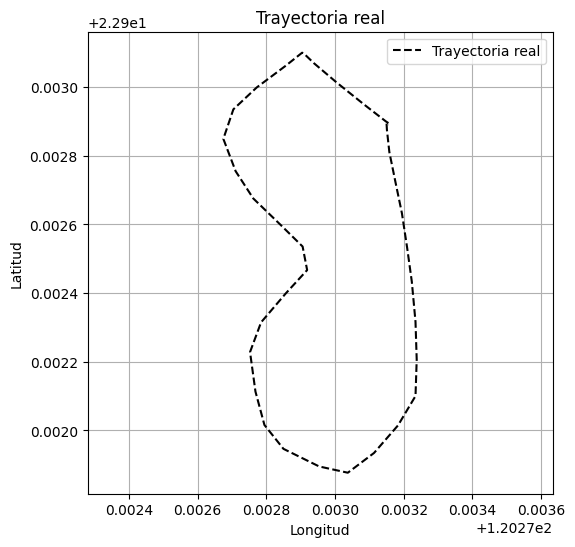

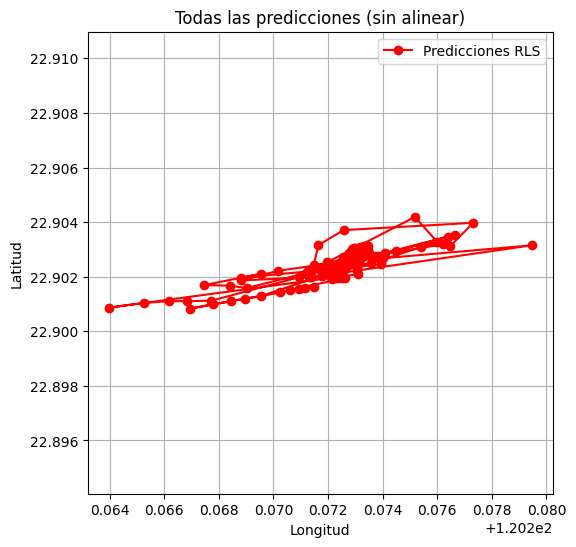

In [150]:
# Convertir a arrays
traj_real_arr = np.array(traj_real)            # (N, 3)
preds_arr = np.vstack(all_preds)           # (N_pred, 3)

# ---- Figura 1: trayectoria real ----
plt.figure(figsize=(6, 6))
plt.plot(traj_real_arr[:, 1], traj_real_arr[:, 0], 'k--', label='Trayectoria real')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Trayectoria real")
plt.grid(True)
plt.legend()
plt.axis('equal')

# ---- Figura 2: predicciones ----
plt.figure(figsize=(6, 6))
plt.plot(preds_arr[:, 1], preds_arr[:, 0], 'ro-', label='Predicciones RLS')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Todas las predicciones (sin alinear)")
plt.grid(True)
plt.legend()
plt.axis('equal')

plt.show()